# Welcome to our ECE532 project
- A Wirelessly Controlled Home Automation System
- A Jupyter notebook on simple audio recognition

We will explain in detail about steps in audio processing, as listed below
* Audio segmentation based on voice activity detection
* MFCC feature extraction
* Dynamic time wrap for sequence distance calculation
* Generating content for C

**WARNING** If you change source code (Python files), you might have to re-import modules or re-run this notebook for your changes to propagate to here. Sometimes, Jupyter is slow and does not respond. Check if you have weird Python3 programs running in the background. Kill them.

## Before we start
We have tested this platform on Ubuntu 16.04. We have not tested many of its functions on Windows, though it should work, if you run everything from Anaconda. We are using Python3. 

For Windows users, be careful about what your `Command Prompt` can execute. 

Now let's make sure our system is up to date. `password_file` is a one line file containing your `sudo` password.

In [1]:
!sudo -S apt-get -y update < password_file
!sudo -S apt-get -y upgrade < password_file

Hit:1 http://security.ubuntu.com/ubuntu xenial-security InRelease
Hit:2 http://us.archive.ubuntu.com/ubuntu xenial InRelease
Hit:3 http://us.archive.ubuntu.com/ubuntu xenial-updates InRelease
Hit:4 http://us.archive.ubuntu.com/ubuntu xenial-backports InRelease
Hit:5 https://packages.microsoft.com/repos/vscode stable InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages were automatically installed and are no longer required:
  libllvm4.0 libprotoc9v5 linux-headers-4.10.0-28
  linux-headers-4.10.0-28-generic linux-headers-4.13.0-26
  linux-headers-4.13.0-26-generic linux-headers-4.13.0-31
  linux-headers-4.13.0-31-generic linux-headers-4.13.0-32
  linux-headers-4.13.0-32-generic linux-headers-4.13.0-36
  linux-headers-4.13.0-36-generic linux-image-4.10.0-28-generic
  linux-image-4.13.0-26-generic linux-image-4.13.0-31-generic
  linux-image-4.13.0-32-generi

You need to install Audacity, a nice tool for audio processing (available on Windows as well)

In [2]:
!sudo -S apt-get install audacity python3 python3-pip < password_file

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3 is already the newest version (3.5.1-3).
audacity is already the newest version (2.1.2-1).
python3-pip is already the newest version (8.1.1-2ubuntu0.4).
The following packages were automatically installed and are no longer required:
  libllvm4.0 libprotoc9v5 linux-headers-4.10.0-28
  linux-headers-4.10.0-28-generic linux-headers-4.13.0-26
  linux-headers-4.13.0-26-generic linux-headers-4.13.0-31
  linux-headers-4.13.0-31-generic linux-headers-4.13.0-32
  linux-headers-4.13.0-32-generic linux-headers-4.13.0-36
  linux-headers-4.13.0-36-generic linux-image-4.10.0-28-generic
  linux-image-4.13.0-26-generic linux-image-4.13.0-31-generic
  linux-image-4.13.0-32-generic linux-image-4.13.0-36-generic
  linux-image-extra-4.10.0-28-generic linux-image-extra-4.13.0-26-generic
  linux-image-extra-4.13.0-31-generic linux-image-extra-4.13.0-32-generic
  linux-image-extra-4.13.0-36-generic
Use 'su

Let's also install some Python tools to make our life easier

In [3]:
!sudo -S pip3 install webrtcvad librosa matplotlib numpy < password_file

[sudo] password for ubuntu: The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 8.1.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Collecting Audio
You have finished setting up. Now it's time to collect an audio sample (or a bunch, if you wish). You can choose your own audio recording tool, for example Audacity, or Windows voice recorder. 

Afterwards, you should convert them into `16K` sample rate and `16bit` little endian. I prefer using Audacity. The picture below shows the preferred format. Learning some [Audacity tutorial](https://manual.audacityteam.org/man/tutorials.html) would be useful. Nevertheless, post-processing with Audacity should be fairly intuitive. 
<img src="figs/raw_setting.PNG">

Put your processed audio in [audio_lib folder](../audio_lib/). We have prepared 3 samples [open_0](../audio_lib/open_0.raw), [close_0](../audio_lib/close_0.raw), [open_0](../audio_lib/door_0.raw) for you. There is also [open_door_0](../audio_lib/sequences/open_door_0.raw) as a full sequence for testing.

One more thing... to make matplotlib work with Jupyter

In [7]:
# Use this with caution! Only activate if your plots are not working
# %matplotlib notebook

Let's plot `open_door_0.raw` sequence and see what it looks like.

(27727,)
length of audio is 27727


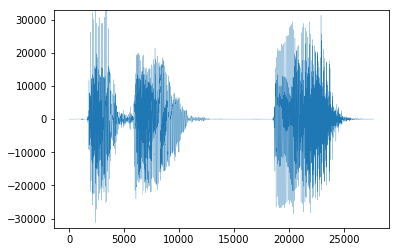

In [8]:
import os, sys
sys.path.append('..')
import importlib

import audio_basics as ab
importlib.reload(ab)

AUDIO_LIB_PATH = os.path.join('..', 'audio_lib')
AUDIO_LIB_SEQUENCES_PATH = os.path.join(AUDIO_LIB_PATH, 'sequences')

audio = ab.open_audio(os.path.join(AUDIO_LIB_SEQUENCES_PATH, 'open_door_0.raw'))
ab.plot_audio([audio], jupyter=True)


Now we normalize this audio to make it not reach +/- 32768. We have `16bit` audio, so limits for recorded audio is `+/- 2**15`. You should see that the audio is scaled down a bit.

Ratio: 0.9500289925840022


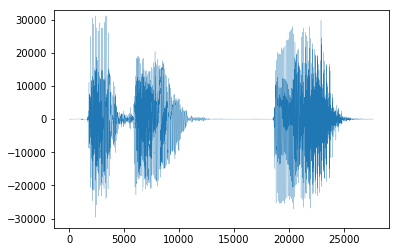

In [9]:
audio = ab.normalize_audio(audio)
ab.plot_audio([audio], jupyter=True)

After segmenting the audio, we want to run it through voice activity detection to separate `open` and `close`. VAD is run for each 32ms window. `16000 * 32 / 1000 = 512` 512 is a number that is nice to hardware. 

-----
1536 0.096
10752 0.672
----
-----
18432 1.152
24576 1.536
----
Ranges where we detected speech
[(1536, 10752), (18432, 24576)]


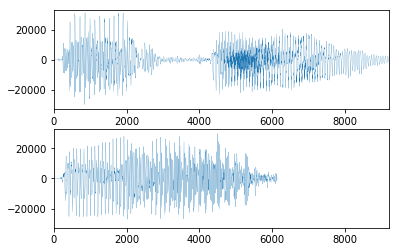

In [10]:
import pprint as pp

import audio_divider as ad
importlib.reload(ad)

speech_ranges, speech_segs = ad.divide_audio(audio)

print ('Ranges where we detected speech')
pp.pprint(speech_ranges)
ab.plot_audio(speech_segs, jupyter=True)

We can try changing the threshold (RMS power) for VAD. In the code below, you can change VAD `threshold` and `silence_count`, then plot the segmented audio. Remember that our audio is in range of `+/- 2**15`.

-----
1536 0.096
10752 0.672
----
-----
18432 1.152
24064 1.504
----


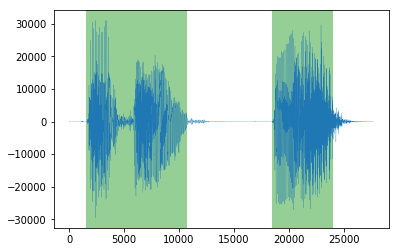

In [11]:
speech_ranges, speech_segs = ad.divide_audio(audio, threshold=2000, silence_count=6)
ad.plot_vad(audio, speech_ranges, jupyter=True)

We will eventually process both of these audio segments, but now, let's focus on `open`. We want to normalize it again because `open` and `door` are not 'as loud as' each other.

In [12]:
audio_seg = ab.normalize_audio(speech_segs[0])

Ratio: 1.0


## MFCC steps
We are finally ready to compute for MFCC. Let's do things one at a time, then we can run through everything at the end.

### Shifting Window
We perform MFCC on a sliding window of 512 samples, with 256 sample step. From here, we will be working on the 0th (you can change it by changing the `seg_index` variable below) segment.

In [13]:
WINDOW_SIZE = 512
SHIFT_WINDOW = 256

max_ratio = 1.0    # in case you only want a portion of the audio
last = int(len(audio_seg) * max_ratio)

num_windows = int((last - WINDOW_SIZE) / SHIFT_WINDOW) + 1
print('Total of ' + str(num_windows) + ' windows')

SEG_INDEX = 0
start_index = SEG_INDEX * 256

cur_audio = audio_seg[start_index : start_index + WINDOW_SIZE]

Total of 35 windows


### Pre-emphasis
Pre-emphasis essentially does `current_volume - PRE_EMPH_COEF * prev_volume`. Try to change pre_emph_coef to see effects of pre-emphasis.

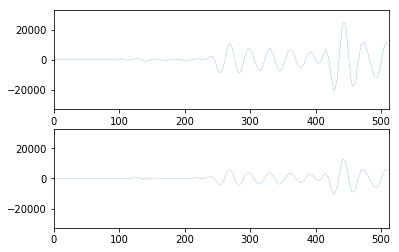

In [14]:
import processor as ap
importlib.reload(ap)

pre_emph_coef = 0.97

pre_emph_audio = ap.pre_emphasis(cur_audio, pre_emph_coef)
ab.plot_audio([cur_audio, pre_emph_audio], jupyter=True)

### Hanning Window

Now we want to apply Hanning Window on this function, which is a fancy window function that reduces effect of having a 'hard boundary'. Details of Hanning Window is available from the [Wikipedia page](https://en.wikipedia.org/wiki/Hann_function).

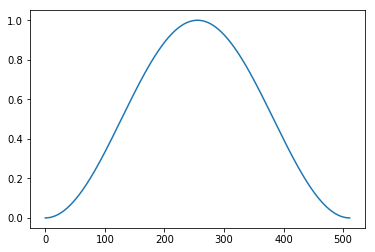

In [15]:
import matplotlib.pyplot as plt
import numpy as np

HANNING_COEF_DEMO = np.hanning(WINDOW_SIZE)

plt.plot(HANNING_COEF_DEMO)
plt.show()

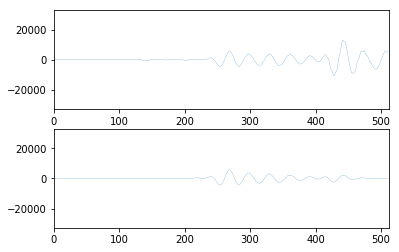

In [16]:
importlib.reload(ap)

hanning_audio = ap.hanning_window(pre_emph_audio)
ab.plot_audio([pre_emph_audio, hanning_audio], jupyter=True)

### FFT

After Hanning Window, we run through the segment through FFT. Equation of FFT can be found on [Wikipedia](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Since audio data is discrete and real, its computation can be simplified. Here, we will simply be using Numpy FFT function. You can find how FFT coefficients are generated at my [fft_generator](../fft_coefficient_generator.py).

For our application, we are only interested in the power of FFT results (FFT returns a real and a complex component. We want its magnitude squared). For easier display, we are plotting **LOG power**. 

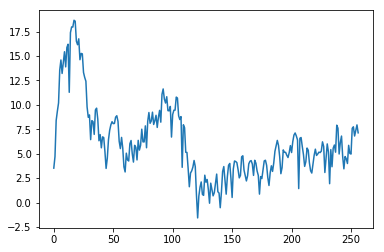

In [17]:
import matplotlib.pyplot as plt
importlib.reload(ap)

fft_powers = ap.compute_fft(hanning_audio)

#plt.plot(fft_powers)
plt.plot(np.log(fft_powers))

### Mel-Power Spectrum

Description of mel-power is available from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale). We first have to generate coefficients for mel-scale computation, then apply it in the form of a matrix multiplication. Log of the mel-scale output is required to find the decibel power. You might have noticed that we are treating FFT powers as a time-series here. We will do the same for DCT (discrete cosine transform).

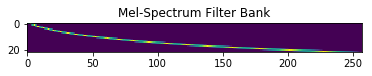

In [40]:
import matplotlib.pyplot as plt

import pprint as pp
importlib.reload(ap)

global MEL_FILTER_BANK
MEL_FILTER_BANK = []

filter_bank = ap.generate_filter_bank() 
#pp.pprint(filter_bank)

plt.title('Mel-Spectrum Filter Bank')
plt.imshow(filter_bank)

In [ ]:
importlib.reload(ap)

processed_mel = ap.process_mel(fft_powers)
plt.plot(processed_mel)

### Discrete Cosine Transform

DCT is again treating the mel-scale result as a time-series signal. Description of DCT (DCT-II) is also, again, yes, from [Wikipedia](https://en.wikipedia.org/wiki/Discrete_cosine_transform). Like mel-scale computation, we first compute all coefficients for DCT, then apply a matrix multiplication to data.

shape of DCT coefficients: (22, 22)


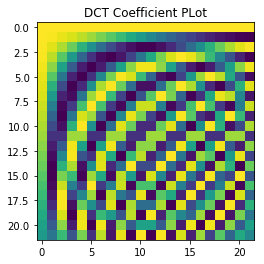

In [38]:
import matplotlib.pyplot as plt
import pprint as pp
importlib.reload(ap)

global DCT_COEF
DCT_COEF = []

dct_matrix = ap.generate_dct_coeffs() 
#pp.pprint(dct_matrix)

plt.title('DCT Coefficient PLot')
plt.imshow(dct_matrix)

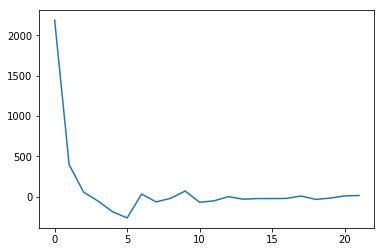

In [39]:
mfcc = ap.dct(processed_mel)
plt.plot(mfcc)

### Final Processing - Re-scaling

Taking a closer look at the graph above, you'll see that the first few terms are fairly large compared to others. This is because the first few terms represent low frequency terms in the original audio 'space', so they are probably related to how loud you were, or, the difference between 'OH' and 'PH'. We want to scale it to reduce such difference. 

Let's plot the scaling coefficients first.

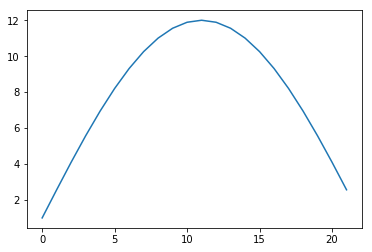

In [21]:
import matplotlib.pyplot as plt
import pprint as pp
importlib.reload(ap)

LIFT = 1 + (ap.NUM_MFCC / 2) * np.sin(np.pi * np.arange(ap.NUM_MFCC) / ap.NUM_MFCC)

plt.plot(LIFT)

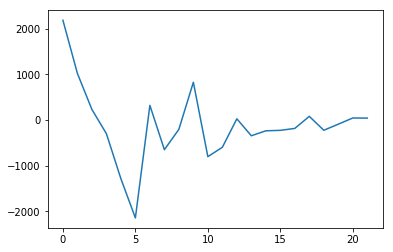

In [22]:
import matplotlib.pyplot as plt
import pprint as pp
importlib.reload(ap)

final_mfcc = ap.re_scaling(mfcc)

plt.plot(final_mfcc)

Problem here is that, the first few terms are still rather large. We can choose to ignore them when we calculate for dynamic time wrap. Since DTW only cares about Cartesian distance (normal) between vectors, scale of these terms actuall matter. 

## Complete MFCC Routine

Now let's run through the above for an entire word. Remember that we have segmented the word `open` using VAD. Let's find the MFCC spectrum of this word.

In [23]:
importlib.reload(ap)

target_mfcc, not_scaled, used_audio = ap.workflow(audio_seg)

generate_filter_bank time taken = 0.002
shape of DCT coefficients: (22, 22)
generate_dct_coefficients time taken = 0.001
Total of 35 windows
Processed 27.78%
Processed 36.11%
Processed 47.22%
Processed 55.56%
Processed 66.67%
Processed 75.0%
Processed 86.11%
==> Done


We can actually plot this MFCC specturm in a 2D graph. You'll see that the un-scaled version is almost the same as `librosa` (a popular audio processing library) results. The scaled version is easier to deal with for reasons we described above.

librosa mfcc shape (35, 22)


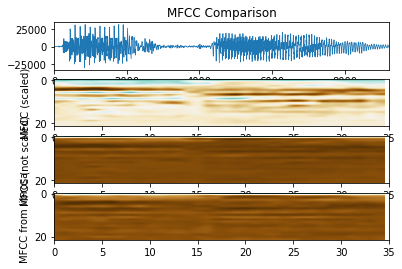

In [24]:
importlib.reload(ap)

librosa_mfcc = ap.compute_using_librosa(audio_seg)
ap.plot_mfcc('MFCC Comparison', target_mfcc, not_scaled, librosa_mfcc, audio_seg)

## Dynamic Timewrap

We have only processed 1 audio segment so far! We have nothing to compare it against. Neverthless, we can show its concepts here. One more time, you can find pseudocode for DTW on [Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping). An innovation on our part is that we have introduced a penalty term for difference in length. It can be expressed as the following.

```python
len_diff = max(abs(i - j), 1)

d1 = cost * len_diff + dtw_array[i - 1][j]
d2 = cost * len_diff + dtw_array[i][j - 1]
d3 = cost * max(len_diff / 2, 1) + dtw_array[i-1][j-1]
```

It's not too easy to plot things nicely when vectors are 2D. Feel free to search up [Levenstein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance). It is the essentially the same thing, except being much easier to visualize (1D, discrete data points versus multi-D continuous data).

Run a few times to see how we 'fill in' for segments of different length.

(7, 0)->(8, 1)->(9, 2)->(10, 3)->(11, 4)->(12, 4)->(13, 5)->(14, 6)->(15, 7)->(16, 8)->(17, 8)->(18, 9)->(19, 9)->(20, 10)->(21, 11)->(22, 12)->(23, 13)->(24, 14)->(25, 15)->(26, 16)->(27, 16)


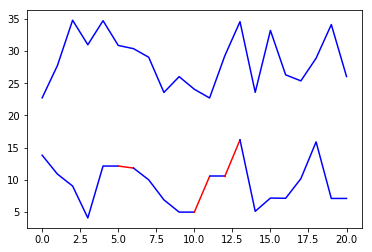

Distance: 496.3601495391246


In [26]:
import dynamic_time_wrap as dtw
importlib.reload(dtw)

a1_dim = (28, 3)
a2_dim = (17, 3)

v1, v2 = dtw.sequence_generator(a1_dim, a2_dim)
result = dtw.dtw_workflow(v1, v2, True) 

print('Distance: ' + str(result))

## Generate Audio Library

As said, we had nothing to compare against. We need to generate a library for comparison. In the beginning, we only had 3 audio samples, `open`, `close` and `door`. Generating a library is essentially the same as running the MFCC algorithm above again. I have wrapped it nicely to save some time. 

The code below will execute our routine for all files in the [audio directory](../audio_lib). If you have other processed audios, put them in now. 

In [27]:
import audio_library as al
importlib.reload(al)

mfcc_libs = al.generate_libraries(jupyter=True)

Generating open_0.raw
(12345,)
length of audio is 12345
-----
5632 0.352
13824 0.864
----
Speech range: [(5632, 13824)] Total Length: 20345
Ratio: 1.0843905667607203
generate_filter_bank time taken = 0.001
shape of DCT coefficients: (22, 22)
generate_dct_coefficients time taken = 0.001
Total of 31 windows
Processed 28.12%
Processed 37.5%
Processed 46.88%
Processed 56.25%
Processed 65.62%
Processed 75.0%
Processed 87.5%
==> Done
saving ../audio_lib/open_0.mfcc
Generating close_0.raw
(13872,)
length of audio is 13872
-----
5120 0.32
14848 0.928
----
Speech range: [(5120, 14848)] Total Length: 21872
Ratio: 1.0581820654021348
generate_filter_bank time taken = 0.002
shape of DCT coefficients: (22, 22)
generate_dct_coefficients time taken = 0.002
Total of 37 windows
Processed 26.32%
Processed 36.84%
Processed 47.37%
Processed 55.26%
Processed 65.79%
Processed 76.32%
Processed 86.84%
==> Done
saving ../audio_lib/close_0.mfcc
Generating door_0.raw
(4451,)
length of audio is 4451
-----
4096 0.2

Then we can run compare our previous result against all generated MFCCs. We pick the one with the shortest distance. We could have used a kNN like approach, but `k=1` is good enough. Note that we are using 3rd MFCC and beyond for comparison, skipping the first few large terms. Remember that the audio_segment we put in was `open`.

In [28]:
import dynamic_time_wrap as dtw
importlib.reload(dtw)

distances = []
for m in mfcc_libs:
    distance = dtw.dtw_workflow(mfcc_libs[m][:, 3:], target_mfcc[:, 3:])
    distances.append((distance, m))

distances.sort()
pp.pprint(distances)
possible_word = distances[0][1].split('_')[0]

print('Possible word is ' + str(possible_word))

[(62487.89854956647, 'open_0'),
 (95840.0373178309, 'close_0'),
 (455970.84915722767, 'door_0')]
Possible word is open


## Entire Flow

You have finally finished looking through each part of this algorithm! Good job. 

Simply put, the next step is just looping the entire thing above and process the next segment. The code below does the entire flow again, from the very beginnig. All custom settings you had will be lost. Rest assured though, the settings we kept in original source files work pretty well.

In [29]:
import main
importlib.reload(main)

phrase = main.workflow(os.path.join(AUDIO_LIB_SEQUENCES_PATH, 'open_door_0.raw'))

print('Phrase is ' + str(phrase))

loading ../audio_lib/open_0.mfcc
loading ../audio_lib/door_0.mfcc
loading ../audio_lib/close_0.mfcc
(27727,)
length of audio is 27727
-----
1536 0.096
10752 0.672
----
-----
18432 1.152
24576 1.536
----
[(1536, 10752), (18432, 24576)]
Ratio: 0.9500289925840022
generate_filter_bank time taken = 0.001
shape of DCT coefficients: (22, 22)
generate_dct_coefficients time taken = 0.001
Total of 35 windows
Processed 27.78%
Processed 36.11%
Processed 47.22%
Processed 55.56%
Processed 66.67%
Processed 75.0%
Processed 86.11%
==> Done
[(58630.432762064505, 'open_0'),
 (89740.88608951087, 'close_0'),
 (441392.4406436493, 'door_0')]
Ratio: 0.994079514609612
generate_filter_bank time taken = 0.002
shape of DCT coefficients: (22, 22)
generate_dct_coefficients time taken = 0.001
Total of 23 windows
Processed 29.17%
Processed 37.5%
Processed 45.83%
Processed 58.33%
Processed 66.67%
Processed 75.0%
Processed 87.5%
==> Done
[(127744.67913123088, 'door_0'),
 (129009.52130880301, 'open_0'),
 (268356.3111795

## Generating C Code

Last but not least. You can try out our routine to generate C files `.c` and `.h`. We only generate file contents, you can choose how/where those content should go. We used this functionality to port our algorithm to `Microblaze` platform for it to run on FPGA.

Let's try generating a storage file for the audio library. You can read our [c_arr_printer](../c_arr_printer.py) to see how arrays are printed. Fairly simple.

In [30]:
import audio_library as al
importlib.reload(al)

mfcc_libs = al.load_libraries(jupyter=True)

al.generate_c_lib(mfcc_libs)

loading ../audio_lib/open_0.mfcc
loading ../audio_lib/door_0.mfcc
loading ../audio_lib/close_0.mfcc
// For .c file
vartab varTable_1[] = {
    {"close_0", CLOSE ,&close_0, 37},
    {"open_0", OPEN ,&open_0, 31}
};

vartab varTable_2[] = {
    {"door_0", DOOR ,&door_0, 13},
};




//--- Start of group 1 -----

// close_0 is [37][22]
float close_0[814] = {
 2136.7095657048176 , 1030.0693751525116 , 611.870218722228 , -574.9246957483861 , -600.0423074466235 , -885.0465790352458 , -41.334004540463845 , -426.47638578001295 , -765.1201432524481 , -123.49994882088843 , 93.69567448211922 ,
 -99.63846262450284 , -530.8626705778834 , 29.881181990507862 , -290.25900047355015 , -170.53283409005013 , -123.00466100427195 , -262.6420313753207 , 178.97211898461046 , -148.61679301693454 , 87.08640463135441 , 19.093939495438384 ,

 2867.0116161543033 , 862.0548359978087 , 312.82618181355457 , -648.5791280913589 , -926.8031242926729 , -1383.6452751584143 , 108.43795697927406 , -359.8412239617191 , -951.9